In [1]:
import numpy as np
import pandas as pd
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
eps = 1e-8 

In [3]:
def load_dataset():
    # YOUR CODE STARTS
    return pd.read_csv('dataset.csv')

In [4]:
df = load_dataset()

In [5]:
def normalise(df):
    # YOUR CODE STARTS
    non_categ = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    for i in range(len(df.columns)):
        if df.columns[i] in non_categ:
            df[df.columns[i]] = (df[df.columns[i]]-df[df.columns[i]].mean())/(df[df.columns[i]].std())
    return df

In [6]:
df = normalise(df)

In [7]:
def get_features(df):
    X = df.iloc[:,:len(df.columns)-1]
    return X.values
def get_targets(df):
    y = df.iloc[:,13:14]
    return y.values

In [8]:
X = get_features(df)
y = get_targets(df)

In [9]:
X_train = np.array(X[:258])
X_test = np.array(X[258:])
y_train = y[:258].reshape(1,-1)
y_test = y[258:].reshape(1,-1)

In [10]:
def Initialization(I, H1, H2, O):
    '''
    Weights are initialized to random values in the range [0, 0.01) using np.random.rand appropriately and
    biases are initialized to zero. The dimensions of the
    parameters as as follows:- 

          W1: First layer weights; has shape (H1, I)
          b1: First layer biases; has shape (H1, 1)
          W2: Second layer weights; has shape (H2, H1)
          b2: Second layer biases; has shape (H2, 1)
          W3: Third layer weights; has shape (O, H2)
          b2: Third layer biases; has shape (O, 1)

          Inputs:
          - I: The number of features of the input data.
          - H1: The number of neurons in the hidden layer - 1.
          - H2: The number of neurons in the hidden layer - 2.
          - O: The number of outputs(i.e. 1).

          Outputs:
          - paramters_final: List containing of parameters 
          after they are initialized with appropriate values in this order:
          [W1, b1, W2, b2, W3, b3]
        '''

    W1 = np.random.rand(H1,I)/100
    W2 = np.random.rand(H2,H1)/100
    W3 = np.random.rand(O,H2)/100
    b1 = np.zeros((H1,1))
    b2 = np.zeros((H2,1))
    b3 = np.zeros((O,1))
    return W1, b1, W2, b2, W3, b3

In [11]:
def feed_forward(X, parameters):
    '''
    Compute the output of a full forward pass of the network.
        
    Using the formulae given below, apply 'forward prop' for each layer according to the defined architecture

    z = WX + b
    a = g(z)  {g being the non linear function}

    Inputs:
    - X : Input data of shape (13, -1). Each X[i] is a feature and each X[:][i] is a training sample
    - parameters: List containing the parameters of the model

    Outputs:
    - y_out : Numpy array with final outputs of shape (1, -1)
    - l : List containing the activation and linear outputs of each layer in the following fashion
      [z1,a1,z2,a2,z3,a3]
    '''
    # YOUR CODE STARTS
    a = X
    no_of_layers = int(len(parameters)/2)
    l = []                             #list of activation and linear outputs
    for layer in range(no_of_layers):
        z = np.dot(parameters[2*layer],a) + parameters[(2*layer+1)][0]
        if (layer+1) == no_of_layers :
            a = sigmoid(z)
        else :
            a = np.maximum(0,z)
        l.append(z)
        l.append(a)
    return a , l

In [12]:
def loss_compute(y_pred, yd):
    '''
    Inputs: 
    - y_pred: numpy array containing predicted values of target
    - yd: numpy array containing desired values of y given in the 
    dataset

    Outputs:
    - loss: Calculate and return the loss using the above formula
    '''
    return (1/np.size(y_pred))*np.sum(((-1)*(yd*np.log(y_pred+eps)))-((1-yd)*np.log(1-y_pred+eps)))  

In [13]:
def regularization_L2(lmbda, W1, W2, W3, m):
    '''
    Inputs:
    - lmbda: Regularization parameter
    - W1, W2, W3: numpy arrays containing weights of the model
    - m: no of examples

    Outputs:
    - total_reg_loss: sum of L2 regularization loss of each layer
    '''
    return (1/m)*(lmbda/2)*(np.sum(W1*W1)+np.sum(W2*W2)+np.sum(W3*W3))

In [14]:
def sigmoid(z):
    z = z.astype(np.float128)
    return 1/(1 + np.exp(-z)) 

In [15]:
def drelu(z):
    return (lambda z: 1*(z>0))(z)

def dSigmoid(z):
    return (lambda z: sigmoid(z)*(1-sigmoid(z)))(z)

In [16]:
def back_prop_linear(da_layer, z_layer, input, act_fxn, m, lmbda, weight):
    '''
    Inputs:
    - da_layer: derivative of variable 'a' of that layer
    - z_layer: numpy array of 'z' values
    
    - input: input value of that layer, for example, X is the
    input for the first layer, and for other layers, it is the activation A of the previous layer
    
    - act_fxn: string containing the name of the activation 
    function used in that layer,i.e. 'sigmoid' or 'relu' (depending on this, the appropriate function is called)
    
    - m: number of datapoints
    - lmbda: regularization parameter
    - weight: weights of that particular layer
  
      Outputs:
    - dz: returns the derivative of linear function variable
    - dW: returns the change in weights for that layer
    - db: returns the change in bias for that layer
    '''
    if act_fxn == 'relu':
        dz = da_layer * drelu(z_layer)
    else:
        dz = da_layer * dSigmoid(z_layer)
    dW = (1/m)*(np.matmul(dz, input.transpose())) + (1/m)*lmbda*weight
    db = (1/m)*np.sum(dz, axis=1)
    db = db.reshape((db.shape[0], 1))
    return dz, dW, db

In [17]:
def back_prop_actf(W_plusone, dz_plusone):
    '''
    Inputs:
    - W_plusone: Weights of the next layer
    - dz_plusone: Derivative of the linear function of the next
    layer

    Outputs:
    - act_dtive: returns the derivative of activation function variable
    '''
    return np.dot(W_plusone.transpose(), dz_plusone)

In [18]:
def Backpropagation1(X, yd, l, y_pred, parameters, lmbda):
    '''
      Inputs:
      - X: Input features - shape (no of features, no of examples)
      - yd: y desired values(labels given in dataset)
      - l: list containing values of 'z' and 'a' of each layer
      - parameters: list containing weights and biases of each layer
      - lmbda: regularization parameter

      Outputs:
      - grad: dictionary containing the change in the values of weights
      and biases with keys 'dW1','db1','dW2','db2','dW3','db3' 
    '''
    no_of_layers = int(len(parameters)/2)

    da3 = -(np.divide(yd,y_pred)-np.divide(1-yd,1-y_pred))
    dz3 , dW3 , db3 = back_prop_linear(da3, l[4], l[3], 'sigmoid', X.shape[1], lmbda, parameters[4])
    da2 =  back_prop_actf(parameters[4] , dz3)
    dz2 , dW2 , db2 = back_prop_linear(da2, l[2], l[1], 'relu', X.shape[1], lmbda, parameters[2])
    da1 =  back_prop_actf(parameters[2] , dz2)
    dz1 , dW1 , db1 = back_prop_linear(da1, l[0], X, 'relu', X.shape[1], lmbda, parameters[0])

    return { "dW1": dW1, "db1": db2, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3 }

In [19]:
def training(X, yd, parameters, eta = 0.05, num_iters=3000, lmbda = 0.1):
    '''
      Inputs:
      - X: Input features - shape (no of features, no of examples)
      - yd: y desired values(labels given in dataset)
      - eta: learning rate
      - num_iters: number of iterations
      - lmbda: regularization parameter

      Outputs:
      - history: list of loss at the start of each iteration 
      - parameters: the final parameters 
    '''
    history = []
    parameters = list(parameters)
    for i in range(num_iters):
        y_pred , l = feed_forward(X , parameters)
        grad = Backpropagation1(X, yd, l, y_pred, parameters, lmbda)
        for i , key in enumerate(grad) :
            parameters[i] = parameters[i] - (eta*grad[key])
        loss = loss_compute(y_pred , yd) + regularization_L2(lmbda, parameters[0], parameters[2], parameters[4], X.shape[1])
        history.append(loss)
    return history , parameters

In [20]:
np.random.seed(4)
parameters = Initialization(13, 100, 100, 1)
losses, parameters_final = training(X_train.T, y_train,parameters, eta = 0.05, num_iters=3000, lmbda = 0.1)

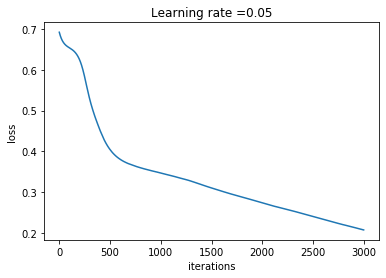

In [21]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.05))
plt.show()

In [22]:
def predict(X, yd, parameters_final):
    '''
      Inputs:
      - X: Input features
      - yd: y desired values(labels given in dataset)
      - parameters_final: final updated values of parameters

      Outputs: 
      - Returns the accuracy 
    '''
    y_pred , l = feed_forward(X , parameters_final)
    y_pred = np.round(y_pred)
    correct_pred = 0 
    for i in range(yd.shape[1]):
        if y_pred[0][i] == yd[0][i]:
            correct_pred = correct_pred + 1
    accuracy = correct_pred/yd.shape[1]
    return accuracy

In [23]:
acc=predict(X_train.T, y_train, parameters_final)
print("Accuracy on train is :- ", acc)
acc=predict(X_test.T, y_test, parameters_final)
print("Accuracy on test is :- ", acc)

Accuracy on train is :-  0.9302325581395349
Accuracy on test is :-  0.5555555555555556
